In [2]:
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras import layers
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam

from matplotlib import pyplot as plt
import numpy as np

import os

In [3]:
print(tf.version.VERSION)

2.12.0


In [4]:
train_images = tf.keras.utils.image_dataset_from_directory(
    "/kaggle/input/women-clothes/clothes", label_mode=None, image_size=(256, 256), batch_size=32
)

Found 16240 files belonging to 1 classes.


height 256
width 256


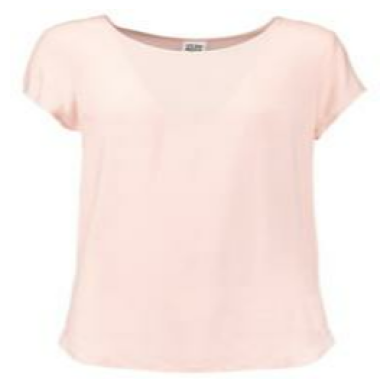

<Figure size 640x480 with 0 Axes>

In [5]:
image_batch = next(iter(train_images))
random_index = np.random.choice(image_batch.shape[0])
random_image = image_batch[random_index].numpy().astype("int32")
print("height", len(random_image))
print("width", len(random_image[0]))
plt.axis("off")
plt.imshow(random_image)
plt.show()
plt.savefig('train_1.png')

In [6]:
# Normalize the images to [-1, 1] which is the range of the tanh activation
train_images = train_images.map(lambda x: (x - 127.5) / 127.5)

In [7]:
# latent dimension of the random noise
LATENT_DIM = 100 
# weight initializer for G per DCGAN paper
WEIGHT_INIT = tf.keras.initializers.RandomNormal(mean=0.0, stddev=0.02) 
# number of channels, 1 for gray scale and 3 for color images
CHANNELS = 3 # UPDATED from 1

input_size = 512

In [8]:
def build_generator():
     # Create a Keras Sequential model
    model = Sequential(name='generator')

    # Prepare for reshape: FC => BN => ReLU layers, note: input shape defined in the 1st Dense layer
    model.add(layers.Dense((input_size // 16) * (input_size // 16) * 512, input_dim=LATENT_DIM))
    model.add(layers.ReLU())

    # 1D => 4D: reshape the output of the previous layer to a 4D tensor
    model.add(layers.Reshape((input_size // 16, input_size // 16, 512)))

    # Upsample to 128x128: apply a transposed CONV => BN => ReLU
    model.add(layers.Conv2DTranspose(256, (4, 4), strides=(2, 2), padding="same", kernel_initializer='glorot_normal'))
    model.add(layers.ReLU())

    # Upsample to 256x256: apply a transposed CONV => BN => ReLU
    model.add(layers.Conv2DTranspose(128, (4, 4), strides=(2, 2), padding="same", kernel_initializer='glorot_normal'))
    model.add(layers.ReLU())

    # Upsample to 512x512: apply a transposed CONV => BN => ReLU
    model.add(layers.Conv2DTranspose(64, (4, 4), strides=(2, 2), padding="same", kernel_initializer='glorot_normal'))
    model.add(layers.ReLU())

    # Final layer: Conv2D with tanh activation to generate the output image
    model.add(layers.Conv2D(CHANNELS, (3, 3), padding="same", activation="tanh"))

    # Return the generator model
    return model

In [9]:
generator = build_generator()

In [10]:
generator.summary()

Model: "generator"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 524288)            52953088  
                                                                 
 re_lu (ReLU)                (None, 524288)            0         
                                                                 
 reshape (Reshape)           (None, 32, 32, 512)       0         
                                                                 
 conv2d_transpose (Conv2DTra  (None, 64, 64, 256)      2097408   
 nspose)                                                         
                                                                 
 re_lu_1 (ReLU)              (None, 64, 64, 256)       0         
                                                                 
 conv2d_transpose_1 (Conv2DT  (None, 128, 128, 128)    524416    
 ranspose)                                               

In [11]:
def build_discriminator(height, width, depth, alpha=0.2):
    # create a Keras Sequential model
    model = Sequential(name='discriminator')
    input_shape = (height, width, depth)

    # 1. first set of CONV => BN => leaky ReLU layers
    model.add(layers.Conv2D(64, (4, 4), padding="same", strides=(2, 2),
        input_shape=input_shape))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU(alpha=alpha))

    # 2. second set of CONV => BN => leacy ReLU layers
    model.add(layers.Conv2D(128, (4, 4), padding="same", strides=(2, 2)))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU(alpha=alpha))

    # 3. third set of CONV => BN => leacy ReLU layers
    model.add(layers.Conv2D(128, (4, 4), padding="same", strides=(2, 2)))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU(alpha=alpha))

    # flatten and apply dropout
    model.add(layers.Flatten())
    model.add(layers.Dropout(0.3))

    # sigmoid in the last layer outputting a single value for binary classification
    model.add(layers.Dense(1, activation="sigmoid"))

    # return the discriminator model
    return model

In [12]:
# build the discriminator model
discriminator = build_discriminator(256, 256, 3) 

In [13]:
discriminator.summary()

Model: "discriminator"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_1 (Conv2D)           (None, 128, 128, 64)      3136      
                                                                 
 batch_normalization (BatchN  (None, 128, 128, 64)     256       
 ormalization)                                                   
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 128, 128, 64)      0         
                                                                 
 conv2d_2 (Conv2D)           (None, 64, 64, 128)       131200    
                                                                 
 batch_normalization_1 (Batc  (None, 64, 64, 128)      512       
 hNormalization)                                                 
                                                                 
 leaky_re_lu_1 (LeakyReLU)   (None, 64, 64, 128)     

In [14]:
class DCGAN(keras.Model):
    def __init__(self, discriminator, generator, latent_dim):
        super().__init__()
        self.discriminator = discriminator
        self.generator = generator
        self.latent_dim = latent_dim
        self.d_loss_metric = keras.metrics.Mean(name="d_loss")
        self.g_loss_metric = keras.metrics.Mean(name="g_loss")

    def compile(self, d_optimizer, g_optimizer, loss_fn):
        super(DCGAN, self).compile()
        self.d_optimizer = d_optimizer
        self.g_optimizer = g_optimizer
        self.loss_fn = loss_fn

    @property
    def metrics(self):
        return [self.d_loss_metric, self.g_loss_metric]

    def train_step(self, real_images):

        batch_size = tf.shape(real_images)[0]
        noise = tf.random.normal(shape=(batch_size, self.latent_dim))

        # Step 1. Train the discriminator with both real images (label as 1) and fake images (classified as label as 0) 
        with tf.GradientTape() as tape:
            # Compute discriminator loss on real images
            pred_real = self.discriminator(real_images, training=True)
            real_labels = tf.ones((batch_size, 1))
            # UPDATED: apply one-sided label smoothing to real labels
            real_labels += 0.05 * tf.random.uniform(tf.shape(real_labels)) 
            d_loss_real = self.loss_fn(real_labels, pred_real)

            # Compute discriminator loss on fake images
            fake_images = self.generator(noise)
            pred_fake = self.discriminator(fake_images, training=True)
            fake_labels = tf.zeros((batch_size, 1))
            # UPDATED: add random noise to fake labels - not needed
            # fake_labels += 0.05 * tf.random.uniform(tf.shape(fake_labels)) 
            d_loss_fake = self.loss_fn(fake_labels, pred_fake)

            # total discriminator loss
            d_loss = (d_loss_real + d_loss_fake)/2
        # Compute discriminator gradients
        grads = tape.gradient(d_loss, self.discriminator.trainable_variables)
        # Update discriminator weights
        self.d_optimizer.apply_gradients(zip(grads, self.discriminator.trainable_variables))

        # Step 2. Train the generator (do not update weights of the discriminator)
        misleading_labels = tf.ones((batch_size, 1)) # G wants D to think the fake images are real (label as 1)

        with tf.GradientTape() as tape:
            fake_images = self.generator(noise, training=True)
            pred_fake = self.discriminator(fake_images, training=True)
            g_loss = self.loss_fn(misleading_labels, pred_fake)
        # Compute generator gradients
        grads = tape.gradient(g_loss, self.generator.trainable_variables)
        # Update generator wieghts
        self.g_optimizer.apply_gradients(zip(grads, self.generator.trainable_variables))

        self.d_loss_metric.update_state(d_loss)
        self.g_loss_metric.update_state(g_loss)

        return {"d_loss": self.d_loss_metric.result(), "g_loss": self.g_loss_metric.result()}

In [15]:
import random
class GANMonitor(keras.callbacks.Callback):
    def __init__(self, num_img=64, latent_dim=100):
        self.num_img = num_img
        self.latent_dim = latent_dim

        # Create random noise seed for visualization during traing
        self.seed = tf.random.normal([64, latent_dim])
#         self.checkpoint_path = "/kaggle/working/checkpoint"
#         self.checkpoint_dir = os.path.dirname(self.checkpoint_path)

    def on_epoch_end(self, epoch, logs=None):
        generated_images = self.model.generator(self.seed)
        generated_images = (generated_images * 127.5) + 127.5
        generated_images.numpy()

        fig = plt.figure(figsize=(8, 8))
        for i in range(self.num_img):
            plt.subplot(8, 8, i+1)
            img = keras.utils.array_to_img(generated_images[i])
#             print(type(img))
#             tf.keras.utils.save_img('img-{:05d}.png'.format(random.randint(0,99999)), img, data_format=None, file_format='png', scale=True, **kwargs)
#             with open('gen_image_{:05d}.png'.format(random.randint(0,99999)), 'wb') as f:
#                 f.write(generated_images[i].numpy())
            plt.imshow(img)
#             plt.title(len(generated_images[i]))
            plt.axis('off')
        plt.savefig('epoch_{:03d}.png'.format(epoch)) 
        plt.show()
#         keras.callbacks.ModelCheckpoint(filepath=self.checkpoint_path, save_weights_only=True, verbose=1)
#         print("Checkpoint saved at : ", self.checkpoint_path)
        

    def on_train_end(self, logs=None):
        self.model.generator.save('generator.h5')

In [16]:
dcgan = DCGAN(discriminator=discriminator, generator=generator, latent_dim=LATENT_DIM)

In [17]:
D_LR = 0.0001 # UPDATED: discriminator learning rate
G_LR = 0.0001 # UPDATED: generator learning rate

dcgan.compile(
    d_optimizer=keras.optimizers.Adam(learning_rate=D_LR, beta_1 = 0.5),
    g_optimizer=keras.optimizers.Adam(learning_rate=G_LR, beta_1 = 0.5),  
    loss_fn=keras.losses.BinaryCrossentropy(),
)

Epoch 1/2
508/508 [==============================] - ETA: 0s - d_loss: -1.0199 - g_loss: 41.8641

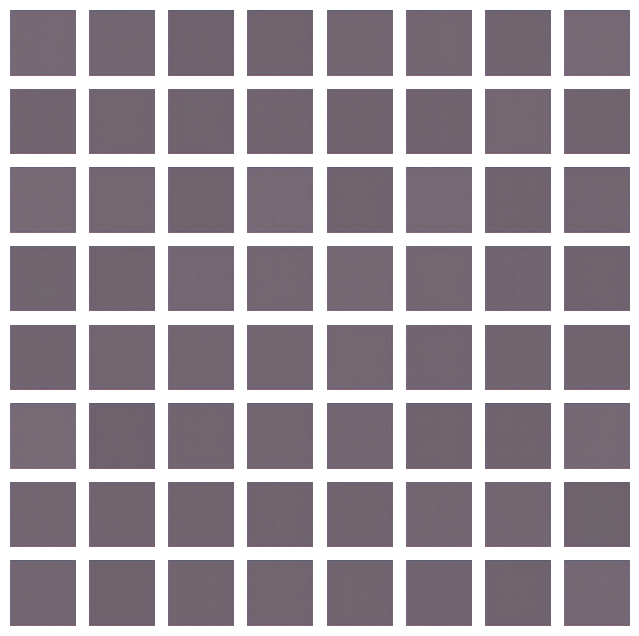

508/508 [==============================] - 224s 411ms/step - d_loss: -1.0199 - g_loss: 41.8641
Epoch 2/2
508/508 [==============================] - ETA: 0s - d_loss: -4.7913 - g_loss: 92.4441

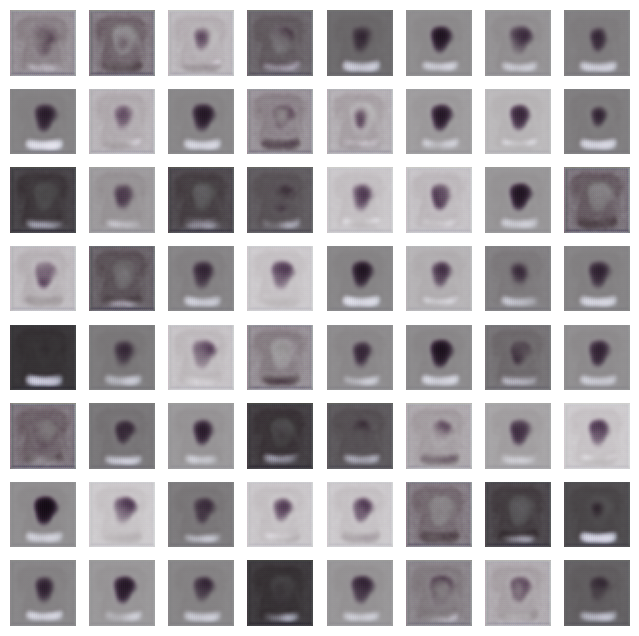

508/508 [==============================] - 207s 406ms/step - d_loss: -4.7913 - g_loss: 92.4441


In [18]:
NUM_EPOCHS = 2 # number of epochs
dcgan.fit(train_images, epochs=NUM_EPOCHS, callbacks=[GANMonitor(num_img=64, latent_dim=LATENT_DIM), keras.callbacks.ModelCheckpoint(filepath='model.h5', save_weights_only=True)])

In [23]:
from tensorflow.keras.models import load_model
loaded_model = load_model('/kaggle/working/generator.h5')


In [24]:
dcgan = DCGAN(discriminator=discriminator, generator=loaded_model, latent_dim=LATENT_DIM)

In [25]:
D_LR = 0.0001 # UPDATED: discriminator learning rate
G_LR = 0.0001 # UPDATED: generator learning rate

dcgan.compile(
    d_optimizer=keras.optimizers.Adam(learning_rate=D_LR, beta_1 = 0.5),
    g_optimizer=keras.optimizers.Adam(learning_rate=G_LR, beta_1 = 0.5),  
    loss_fn=keras.losses.BinaryCrossentropy(),
)

Epoch 1/5
508/508 [==============================] - ETA: 0s - d_loss: 1.0323 - g_loss: 4.8655

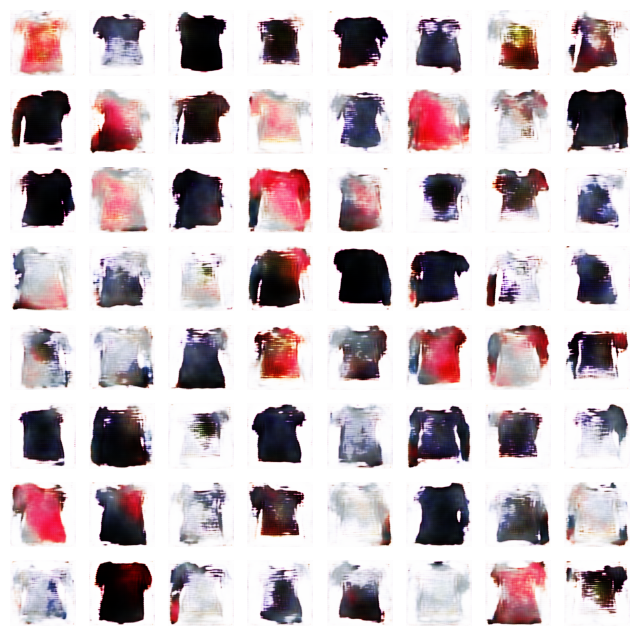

508/508 [==============================] - 211s 406ms/step - d_loss: 1.0323 - g_loss: 4.8655
Epoch 2/5
508/508 [==============================] - ETA: 0s - d_loss: 1.0527 - g_loss: 3.5930

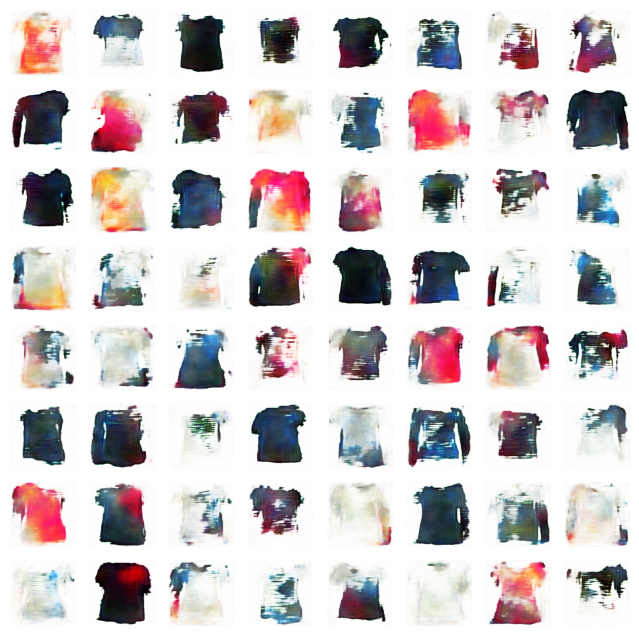

508/508 [==============================] - 207s 406ms/step - d_loss: 1.0527 - g_loss: 3.5930
Epoch 3/5
508/508 [==============================] - ETA: 0s - d_loss: 1.0657 - g_loss: 3.0754

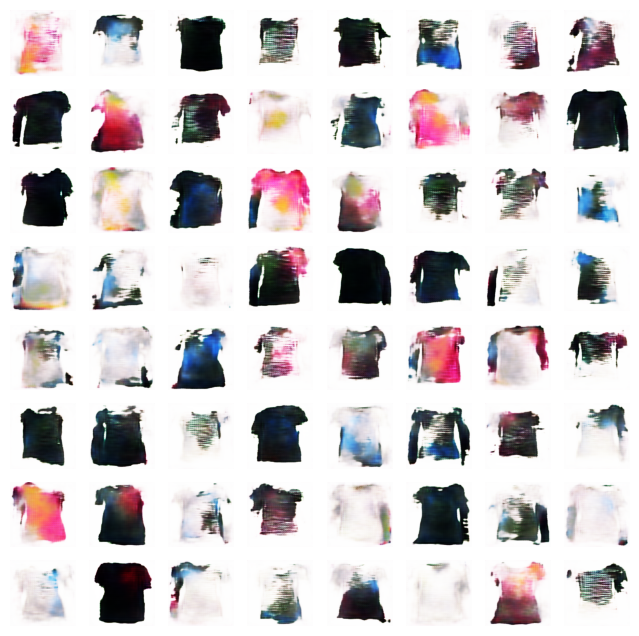

508/508 [==============================] - 207s 407ms/step - d_loss: 1.0657 - g_loss: 3.0754
Epoch 4/5
508/508 [==============================] - ETA: 0s - d_loss: 1.0477 - g_loss: 2.4795

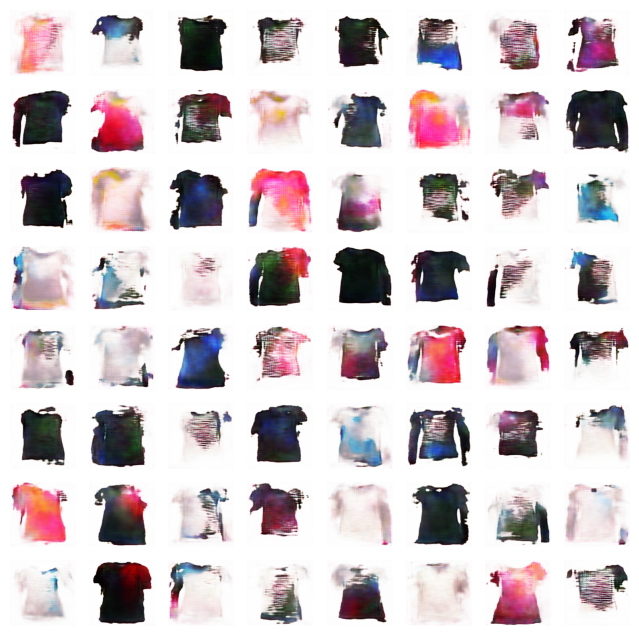

508/508 [==============================] - 207s 406ms/step - d_loss: 1.0477 - g_loss: 2.4795
Epoch 5/5
508/508 [==============================] - ETA: 0s - d_loss: 1.0068 - g_loss: 2.1989

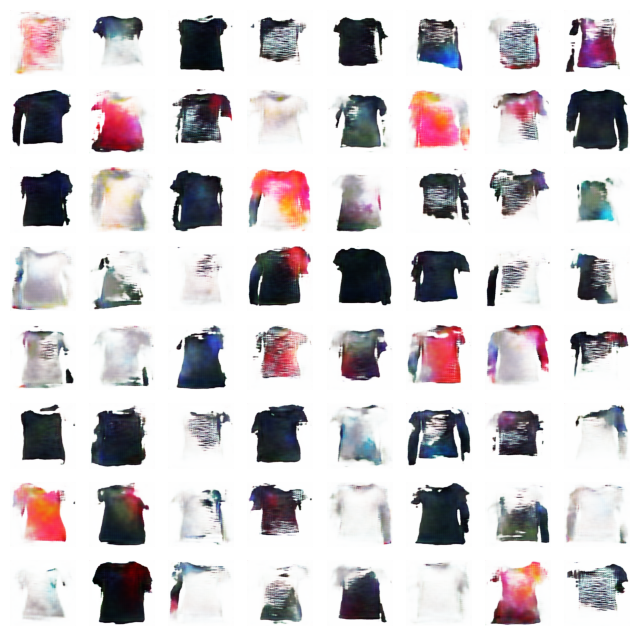

508/508 [==============================] - 207s 406ms/step - d_loss: 1.0068 - g_loss: 2.1989


In [26]:
NUM_EPOCHS = 5 # number of epochs
dcgan.fit(train_images, epochs=NUM_EPOCHS, callbacks=[GANMonitor(num_img=64, latent_dim=LATENT_DIM), keras.callbacks.ModelCheckpoint(filepath='model.h5', save_weights_only=True)])